# Import the Packages and Data

In [9]:
import sys
sys.path

['/home/a39083/UNET-Sampling/crimac_unet',
 '/opt/conda/lib/python37.zip',
 '/opt/conda/lib/python3.7',
 '/opt/conda/lib/python3.7/lib-dynload',
 '',
 '/opt/conda/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages/IPython/extensions',
 '/home/a39083/.ipython',
 '/home/a39083/UNET-Sampling/crimac_unet']

In [1]:
from data.echogram import DataReaderZarr, get_data_readers
import numpy as np
from tqdm import tqdm
import dask
import pandas as pd
import matplotlib.pyplot as plt

dask.config.set(**{'array.slicing.split_large_chunks': False})

#  Path to surveys
survey_path = '/data/'

#  Get list of relevant surveys
surveys = ['2019/S2019847/ACOUSTIC/GRIDDED/S2019847_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

# Or alternatively ...
# readers = get_data_readers()

patch_size = (256, 256)  # x, y

# Creating Coordinates and Metadata Structure

In [2]:
survey = readers[0]

n_pings, n_range = survey.shape

xs = np.arange(patch_size[0] // 2, n_pings - patch_size[0] // 2, patch_size[0])
ys = np.arange(patch_size[1] // 2, patch_size[1] * 3 - patch_size[1] // 2, patch_size[1])

(xs, ys) = np.meshgrid(xs, ys)
coordinate_list = np.array([xs.ravel(), ys.ravel()]).T[:-2,:] # Last two rows excluded

fish_categories = list(survey.fish_categories)

# x, y, mean, median, n_pixels_below_seabed, Nr of fish categories + ignore + background
data = np.zeros((len(coordinate_list), 2 + 3 + len(survey.fish_categories) + 5))

# Producing Metadata for Each Patch Through the Survey Data¶

In [3]:
for i, (x, y) in tqdm(enumerate(coordinate_list), total=len(coordinate_list)):
    data[i, 0] = x
    data[i, 1] = y

    data_sv = survey.get_data_slice(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                    idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                    return_numpy=False, frequencies=[38000])
    mean_sv = data_sv.mean().values
    median_sv = data_sv.median(dim=['ping_time', 'range']).values

    data[i, 2] = mean_sv # Mean sv value
    data[i, 3] = median_sv # Median sv value

    seabed_mask = survey.get_seabed_mask(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                         idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                         return_numpy=False)
    n_pixels_below_seabed = seabed_mask.sum().values
    data[i, 4] = n_pixels_below_seabed  # Pixels under seabed

    labels = survey.annotation.annotation[:, (x - patch_size[0] // 2):(x + patch_size[0] // 2),
             int(y - patch_size[1] // 2):int(y + patch_size[1] // 2)]

    # Number of Pixels
    data[i, 5] = labels.sel(category=1).sum().values  # Other class
    data[i, 6] = labels.sel(category=27).sum().values  # Sandeel class
    data[i, 7] = labels.sel(category=6009).sum().values  # Possible Sandeel class
    data[i, 8] = 256 * 256 - (data[i, 5] + data[i, 6] + data[i, 7])  # Background class

    # Average Intensity Values
    if data[i, 5] != 0: data[i, 9] = ((data_sv * labels.sel(category=1)).sum() / data[i, 5]).values  # Average Other sv
    if data[i, 6] != 0: data[i, 10] = (
            (data_sv * labels.sel(category=27)).sum() / data[i, 6]).values  # Average Sandeel sv
    if data[i, 7] != 0: data[i, 11] = (
            (data_sv * labels.sel(category=6009)).sum() / data[i, 7]).values  # Average Possible Sandeel sv
    if data[i, 8] == 256 * 256:
        data[i, 12] = mean_sv
    else:
        data[i, 12] = data_sv[0].values[np.logical_and(labels.sel(category=27).values != 1,
                                                       labels.sel(category=1).values != 1,
                                                       labels.sel(category=6009).values != 1)].sum() / data[
                          i, 8]  # Average Background sv

 33%|███▎      | 10243/31128 [5:38:00<9:47:27,  1.69s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 58%|█████▊    | 18060/31128 [9:44:09<9:23:14,  2.59s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 83%|████████▎ | 25763/31128 [13:41:46<2:32:11,  1.70s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable

# Saving the Data

In [ ]:
#np.savetxt("patch_data.csv", data, delimiter=",")
#data = np.loadtxt('patch_data.csv', delimiter=",")

pdata = pd.DataFrame(data)
names = ['x', 'y', 'mean_sv', 'median_sv', 
         'nop_below_seabed', 'nop_other', 'nop_sandeel', 'nop_possandeel', 'nop_background',
         'mean_other', 'mean_sandeel', 'mean_possandeel', 'mean_background']
pdata.columns = names

# Histogram Plots

In [169]:
# Sv transformation function
def db(data, eps=1e-10):
    return 10 * np.log10(data + eps)

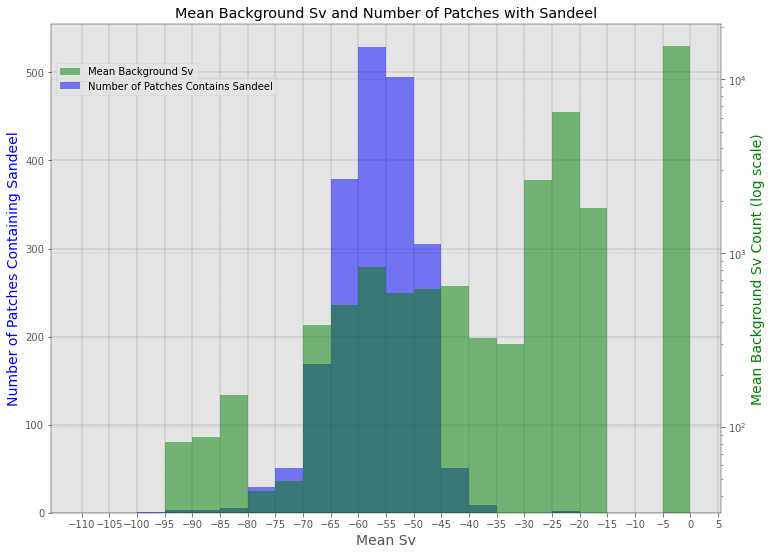

In [219]:
# Histogram of Mean Background Intensity and Number of Patches Containing Sandeel

thr_low = -110 # Lower threshold for Mean Sv Background
thr_up = 0 # Upper threshold for Mean Sv Background
fig_start = -110 # Starting Sv Value of Histogram
fig_finish = 5 # Ending Sv Value of Histogram
s_bin = 5 # Bin size of histogram

filt_bg = ((pdata['mean_background'].apply(lambda x: db(x))>thr_low) & 
           (pdata['mean_background'].apply(lambda x: db(x))<thr_up)) # Background Thresholding filter

fig,ax = plt.subplots(figsize = (12,9))
plt.rcParams["axes.linewidth"] = 0.2
plt.rcParams["axes.edgecolor"] = "black"
plt.title('Mean Background Sv and Number of Patches with Sandeel')
ax.hist(pdata[(pdata['nop_sandeel'] != 0) & filt_bg]
        ['mean_sandeel'].apply(lambda x: db(x)), bins = np.arange(fig_start, fig_finish, s_bin),
         label = 'Number of Patches Contains Sandeel', color='blue', alpha=0.5)

ax.set_xlabel("Mean Sv", fontsize = 14)
ax.set_ylabel("Number of Patches Containing Sandeel",
              color="blue",
              fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
plt.grid(color = 'black', linestyle = '--', linewidth = 0.2)
ax2=ax.twinx()
ax2.hist(pdata[filt_bg]['mean_background'].apply(lambda x: db(x)),
        bins = np.arange(fig_start, fig_finish, s_bin), 
        range = (thr_low, thr_up), alpha = 0.5, label = 'Mean Background Sv',
        color='green', log=True)
ax2.set_ylabel("Mean Background Sv Count (log scale)",
              color="green",
              fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.93))
plt.xticks(np.arange(fig_start, fig_finish+1, s_bin))
plt.grid(color = 'black', linestyle = '--', linewidth = 0.1)
plt.show()

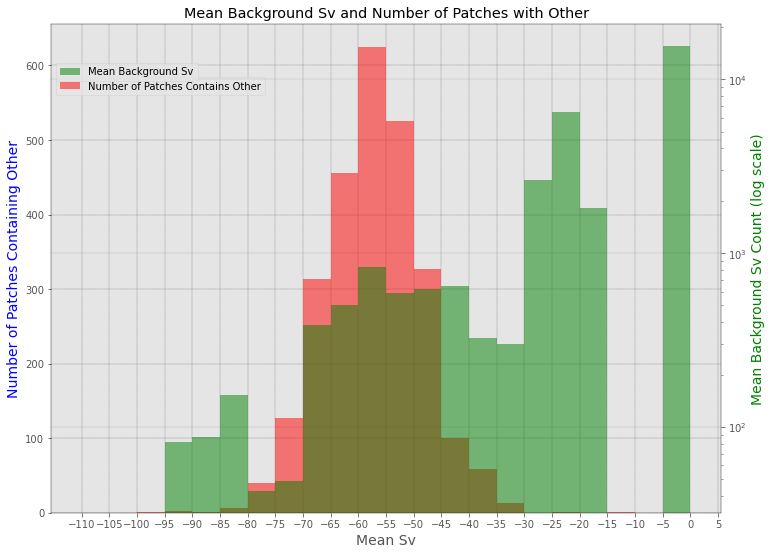

In [297]:
# Histogram of Mean Background Intensity and Number of Patches Containing Sandeel

filt_bg = ((pdata['mean_background'].apply(lambda x: db(x))>thr_low) & 
           (pdata['mean_background'].apply(lambda x: db(x))<thr_up)) # Background Thresholding filter

fig,ax = plt.subplots(figsize = (12,9))
plt.rcParams["axes.linewidth"] = 0.2
plt.rcParams["axes.edgecolor"] = "black"
plt.title('Mean Background Sv and Number of Patches with Other')
ax.hist(pdata[(pdata['nop_other'] != 0) & filt_bg]
        ['mean_other'].apply(lambda x: db(x)), bins = np.arange(fig_start, fig_finish, s_bin),
         label = 'Number of Patches Contains Other', color='red', alpha=0.5)
ax.set_xlabel("Mean Sv", fontsize = 14)
ax.set_ylabel("Number of Patches Containing Other",
              color="blue",
              fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
plt.grid(color = 'black', linestyle = '--', linewidth = 0.2)
ax2=ax.twinx()
ax2.hist(pdata[filt_bg]['mean_background'].apply(lambda x: db(x)),
        bins = np.arange(fig_start, fig_finish, s_bin), 
        range = (thr_low, thr_up), alpha = 0.5, label = 'Mean Background Sv',
        color='green', log=True)
ax2.set_ylabel("Mean Background Sv Count (log scale)",
              color="green",
              fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.93))
plt.xticks(np.arange(fig_start, fig_finish+1, s_bin))
plt.grid(color = 'black', linestyle = '--', linewidth = 0.1)
plt.show()

# Example Ilustrations

mean background sv = 0.5103827  median background sv = 4.0332395e-08
mean background Sv = -2.921040447407553  median background Sv = -73.93270530446175


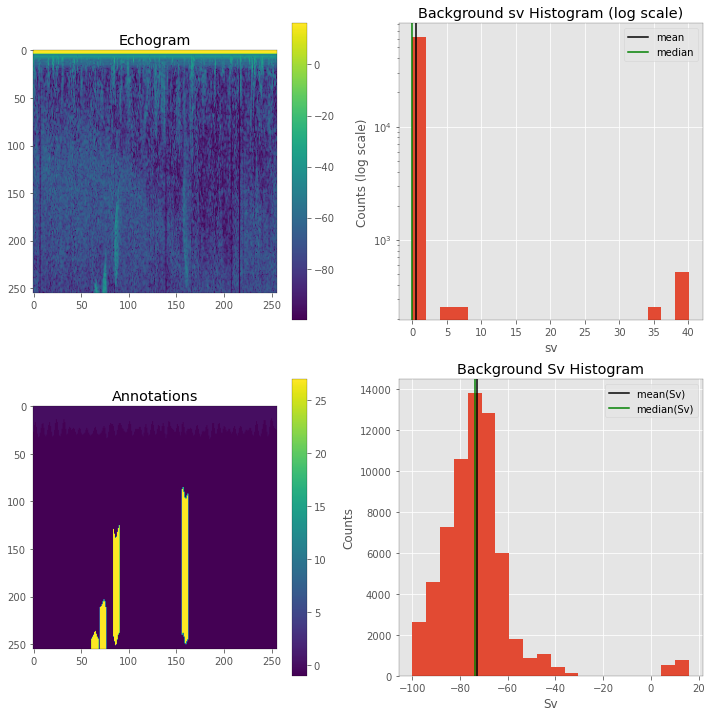

In [336]:
x, y = 46976, 128 

a = survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                        idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                        return_numpy=False, frequencies=[38000])
c = survey.get_label_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                        idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                        return_numpy=True)

plt.figure(figsize = (12,12))
plt.subplot(2,2,1)
plt.title('Echogram')
plt.imshow(db(a[0,:,:].values.T))
plt.grid(None)
plt.colorbar()
plt.subplot(2,2,3)
plt.title('Annotations')
plt.imshow(c.T)
plt.grid(None)
plt.colorbar()

plt.subplot(2,2,2)
bg = a[0].values[np.logical_or(c==-1, c==0)]
plt.title('Background sv Histogram (log scale)')
plt.xlabel('sv')
plt.ylabel('Counts (log scale)')
plt.hist(bg, bins = 20, log = True)
plt.axvline(x=bg.mean(), color = 'black', label = 'mean')
plt.axvline(x=np.median(bg), color = 'green', label = 'median')
plt.legend()
print('mean background sv =', bg.mean(), ' median background sv =', np.median(bg))
print('mean background Sv =', db(bg.mean()), ' median background Sv =', db(np.median(bg)))

plt.subplot(2,2,4)
plt.hist(db(bg), bins = 20, log = False)
plt.axvline(x=db(bg).mean(), color = 'black', label = 'mean(Sv) ')
plt.axvline(x=np.median(db(bg)), color = 'green', label = 'median(Sv)')

#plt.axvline(x=db(bg.mean()), color = 'red', label = 'Sv(mean)')
#plt.axvline(x=db(np.median(bg)), color = 'blue', label = 'Sv(median)')

plt.title('Background Sv Histogram')
plt.xlabel('Sv')
plt.ylabel('Counts')
plt.legend()
plt.show()


# Summary Patch Information

In [383]:
sb = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']==0)]) # Sandeel + Background
so = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']==0)]) # Sandeel + Other
sp = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']>0)]) # Sandeel + Possandeel
spo = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']>0)]) # Sandeel + Possandeel + Other

ob = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']==0)]) # Other + Background
op = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']>0)]) # Other + Possandeel
pb = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']>0)]) # Possandeel + Background

b = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']==0)]) # Possandeel + Background

In [20]:
!python batch/samplers/background.py

Traceback (most recent call last):
  File "batch/samplers/background.py", line 20, in <module>
    from utils.np import getGrid, nearest_interpolation
ModuleNotFoundError: No module named 'utils'


In [16]:
sys.path

['/home/a39083/UNET-Sampling/crimac_unet',
 '/opt/conda/lib/python37.zip',
 '/opt/conda/lib/python3.7',
 '/opt/conda/lib/python3.7/lib-dynload',
 '',
 '/opt/conda/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages/IPython/extensions',
 '/home/a39083/.ipython',
 '/crimac_unet/utils',
 '/utils',
 '/crimac_unet/batch/samplers']

# Running UNET Code


In [48]:
!PYTHONPATH=/home/a39083/UNET-Sampling/crimac_unet python pipeline_train_predict/train.py

2022-10-22 15:17:34.192657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 15:17:34.395144: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-22 15:17:35.114785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-22 15:17:35.114883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

In [6]:
import torch
torch.cuda.is_available()

True

In [13]:
from batch.samplers.school_seabed import SchoolSeabedZarr
from data.echogram import DataReaderZarr, get_data_readers
import numpy as np
from tqdm import tqdm
import dask
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_closing
from scipy import stats as st
from pandas.plotting import scatter_matrix
import xarray as xr


In [72]:
dask.config.set(**{'array.slicing.split_large_chunks': False})

#  Path to surveys
survey_path = '/data/'

#  Get list of relevant surveys
surveys = ['2018/S2018823/ACOUSTIC/GRIDDED/S2018823_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

# Or alternatively ...
# readers = get_data_readers()

patch_size = (256, 256)  # x, y

In [73]:
survey = readers[0]
denemeschol = SchoolSeabedZarr(readers, patch_size, 128)

Generating objects file with seabed distances ... 


In [76]:
survey.fish_categories

[6009, 27, 1]

In [74]:
denemeschol.get_sample()

ValueError: high <= 0

In [51]:
aa = denemeschol.schools[0][1]
aa

array([[  37475,   37488,     384,     410],
       [  35783,   35784,     388,     413],
       [  39963,   39965,     268,     287],
       ...,
       [3976083, 3976090,     516,     529],
       [3976631, 3976643,     457,     530],
       [3978554, 3978554,     507,     524]])

In [52]:
np.sort(aa[:,3] - aa[:,2])

array([  1,   1,   1, ..., 314, 324, 537])

In [53]:
aa = survey.objects_df
bb = aa.loc[aa.distance_to_seabed < 20]
bboxes = bb[['startpingindex', 'endpingindex', 'upperdepthindex', 'lowerdepthindex']].values
bboxes

array([[  37475,   37488,     384,     410],
       [  35783,   35784,     388,     413],
       [  40119,   40122,     272,     334],
       ...,
       [3975610, 3975624,     578,     587],
       [3975974, 3975992,     588,     596],
       [3976027, 3976037,     593,     596]])

In [54]:
for i in tqdm(range(1000000), maxinterval=1000000):
    aa = denemeschol.get_sample()

100%|██████████| 1000000/1000000 [00:30<00:00, 32665.41it/s]


In [64]:
!PYTHONPATH=/home/a39083/UNET-Sampling/crimac_unet python examples/example_zarr_reader.py

Included fish categories: [1, 27, 6009]
Generating objects file with seabed distances ... 
 Nr of schools in category 1 = 4741
 Nr of schools in category 27 = 2786
 Nr of schools in category 6009 = 477

Number of pings: 3984739
Survey start time: 2019-04-23T16:56:17.438000000
Survey end time: 2019-05-12T19:51:24.954000000
Figure(1600x1600)
Figure(1600x1600)


Included fish categories: [1, 27, 6009]
Generating objects file with seabed distances ... 
 Nr of schools in category 1 = 4741
 Nr of schools in category 27 = 2786
 Nr of schools in category 6009 = 477

Number of pings: 3984739
Survey start time: 2019-04-23T16:56:17.438000000
Survey end time: 2019-05-12T19:51:24.954000000


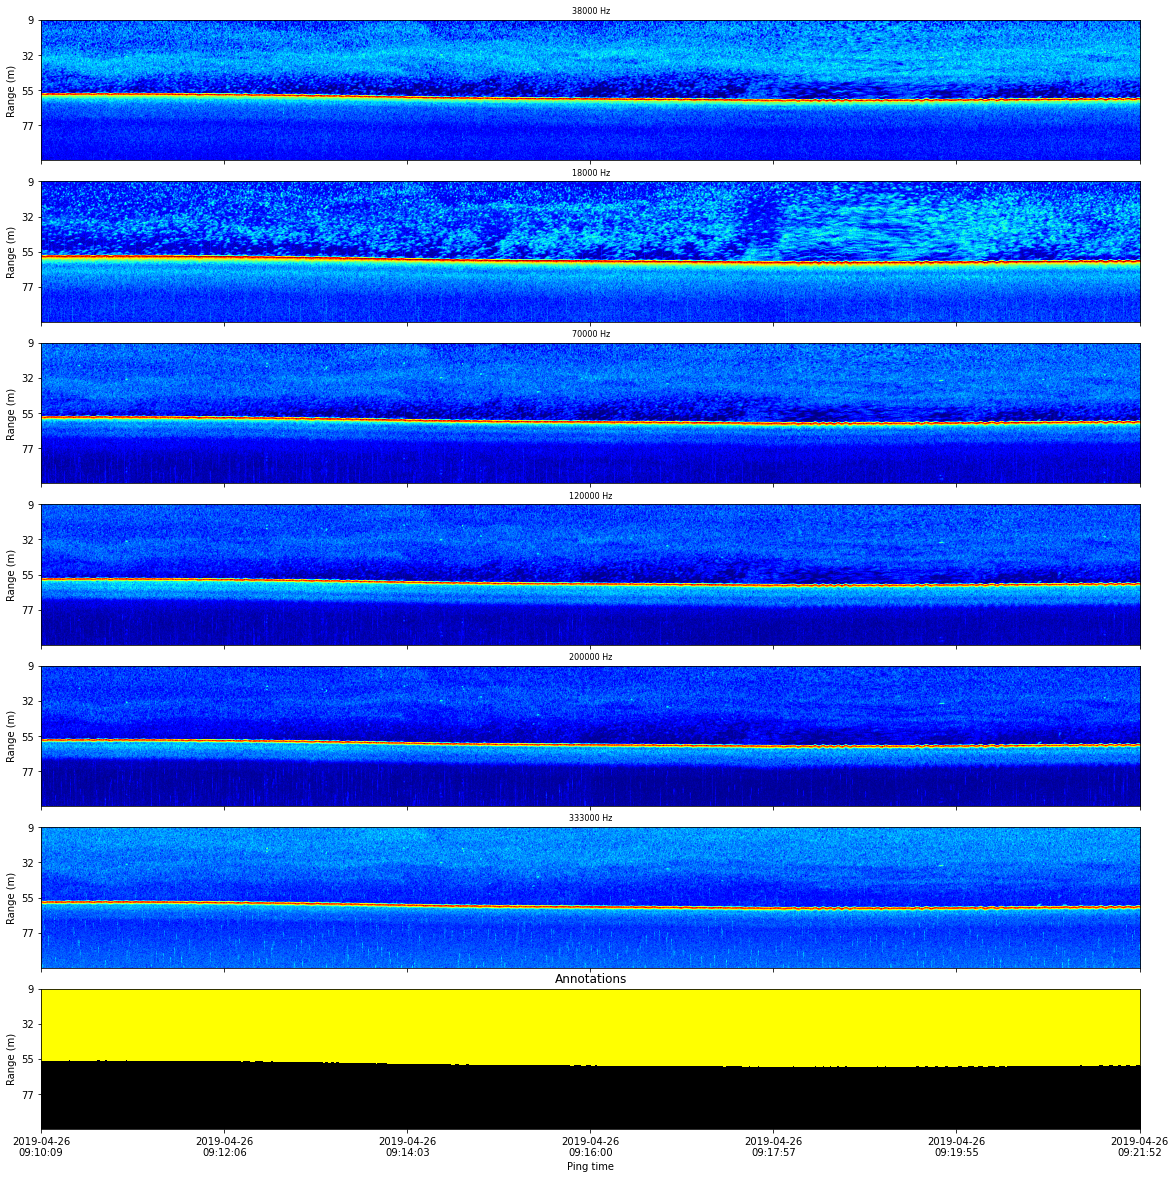

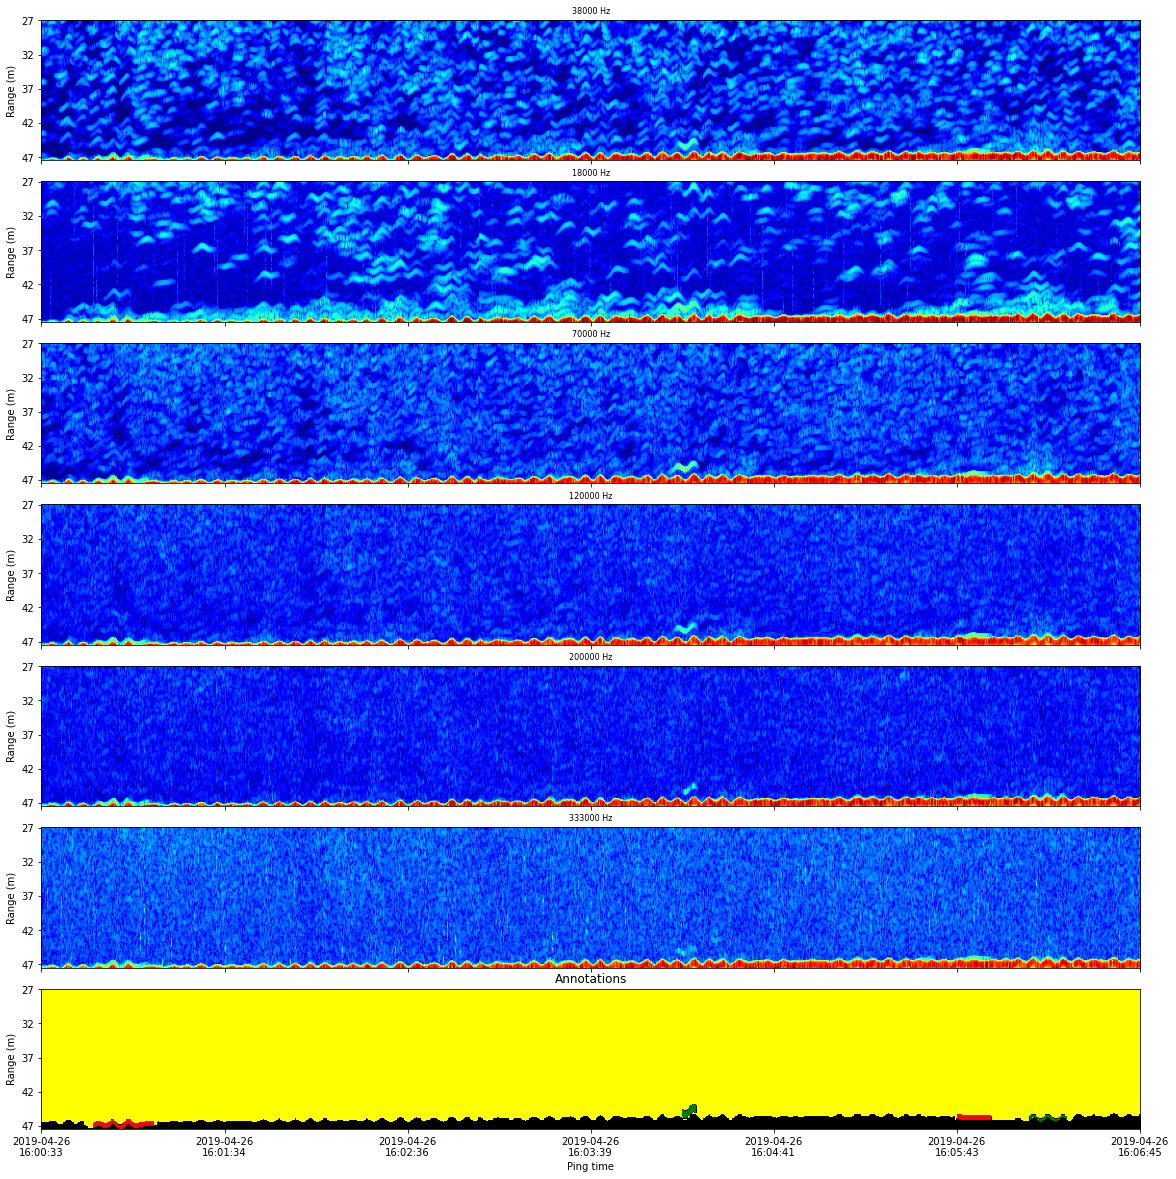

In [71]:
%run '/home/a39083/UNET-Sampling/crimac_unet/examples/example_zarr_reader.py'

In [ ]:
%run '/home/a39083/UNET-Sampling/crimac_unet/pipeline_train_predict/train.py'

 No annotation file found at /data/2019/S2019842/ACOUSTIC/GRIDDED/S2019842_labels.zarr
14 found: ['S2007205', 'S2008205', 'S2009107', 'S2010205', 'S2011206', 'S2013842', 'S2014807', 'S2015837', 'S2016837', 'S2017843', 'S2018823', 'S2019842', 'S2019847', 'S2019847_0511']
Start training
Starting TensorboardLogger - /home/a39083/UNET-Sampling/crimac_unet/log/created_trained_model/
Preparing data samplers
Train: 5 surveys, 2783 raw files, 15697175 pings
Test: 1 surveys, 545 raw files 2215544 pings
Generating objects file with seabed distances ... 
Generating objects file with seabed distances ... 
Generating objects file with seabed distances ... 
Generating objects file with seabed distances ... 
